In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Data Pre-processing
import pandas as pd
import numpy as np

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_Phase_1/train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_Phase_1/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_Phase_1/test.csv')

In [ ]:
train_data.shape

(28520, 772)

In [ ]:
label_columns = ['label_1', 'label_2', 'label_3', 'label_4']
df_train_X = train_data.drop(label_columns, axis=1)
df_train_y = train_data['label_4']
df_valid_X = valid_data.drop(label_columns, axis=1)
df_valid_y = valid_data['label_4']

<Axes: >

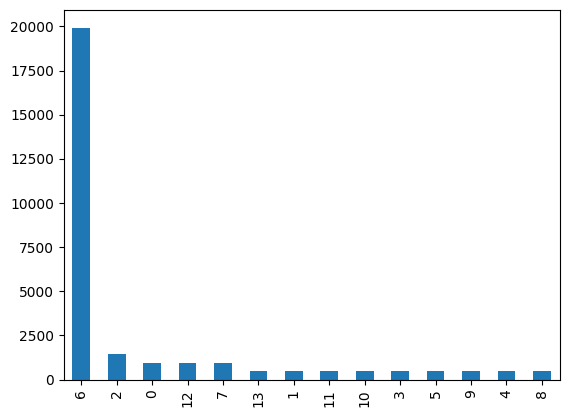

In [ ]:
df_train_y.value_counts().plot(kind='bar')

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy='auto')
df_train_X, df_train_y = oversampler.fit_resample(df_train_X, df_train_y)

<Axes: >

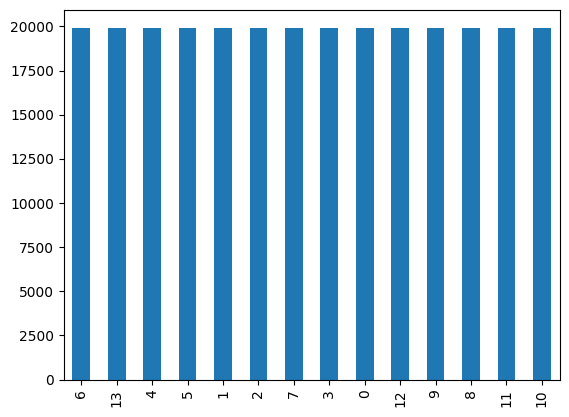

In [ ]:
df_train_y.value_counts().plot(kind='bar')

In [ ]:
import random

# Define the desired number of samples you want to keep
desired_sample_count = 100000  # Adjust this number as needed

# Check if the number of samples exceeds the desired count
if len(df_train_X) > desired_sample_count:
    # Randomly select the desired number of samples
    random_indices = random.sample(range(len(df_train_X)), desired_sample_count)
    df_train_X = df_train_X.iloc[random_indices]
    df_train_y = df_train_y.iloc[random_indices]

<Axes: >

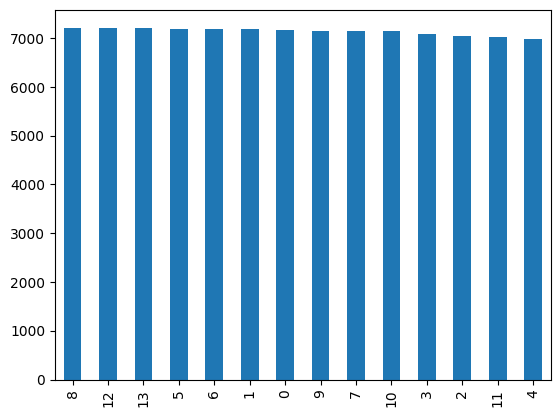

In [ ]:
df_train_y.value_counts().plot(kind='bar')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train_X_scaled = scaler.fit_transform(df_train_X)
df_valid_X_scaled = scaler.transform(df_valid_X)

print(df_train_X_scaled.shape)

(100000, 768)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best = SelectKBest(score_func=f_classif, k=300)

df_train_X_selected = k_best.fit_transform(df_train_X_scaled, df_train_y)
df_valid_X_selected = k_best.transform(df_valid_X_scaled)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

model_after = SVC(kernel='rbf', C=1.0, gamma='scale')
model_after.fit(df_train_X_selected, df_train_y)

y_pred_before = model_after.predict(df_valid_X_selected)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_before = accuracy_score(df_valid_y, y_pred_before)

print("Accuracy:", accuracy_before)

Accuracy: 0.9653333333333334


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.98)
pca.fit(df_train_X_selected)
pca_train_X = pca.transform(df_train_X_selected)
pca_valid_X = pca.transform(df_valid_X_selected)

print(pca_train_X.shape)

(100000, 224)


In [ ]:
model_after = SVC(kernel='rbf', C=1.0, gamma='scale')
model_after.fit(pca_train_X, df_train_y)

y_pred_after = model_after.predict(pca_valid_X)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_after = accuracy_score(df_valid_y, y_pred_after)

print("Accuracy:", accuracy_after)

Accuracy: 0.96


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'degree': [2, 3],
}

random_search = RandomizedSearchCV(
    verbose=1,
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=2,  # Adjust the number of iterations
    scoring='accuracy',
    cv=5,  # Adjust the number of folds
    n_jobs=-1
)

random_search.fit(pca_train_X, df_train_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=2, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10], 'degree': [2, 3],
                                        'kernel': ['linear', 'rbf']},
                   scoring='accuracy', verbose=1)

In [ ]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

In [ ]:
y_pred_tuned = best_estimator.predict(pca_valid_X)
accuracy_tuned = accuracy_score(df_valid_y, y_pred_tuned)
print("Tuned Accuracy:", accuracy_tuned)

Tuned Accuracy: 0.9786666666666667


In [ ]:
best_params

{'kernel': 'rbf', 'degree': 2, 'C': 10}

In [ ]:


# Scale the test data using the same scaler that was fitted on the training data
df_test_X_scaled = scaler.transform(test_data)

# Select the same features using SelectKBest
df_test_X_selected = k_best.transform(df_test_X_scaled)

# Transform the test data using the same PCA model
pca_test_X = pca.transform(df_test_X_selected)

# Use the best-tuned model for predictions on the test data
y_pred_test = best_estimator.predict(pca_test_X)

# Assuming 'y_pred_test' is a numpy array or a list
predictions_df = pd.DataFrame({'Predictions': y_pred_test})

predictions_df.to_csv('svm_predictions_label_4-Layer9.csv', index=False)